In [10]:
import os
import os.path as o
import numpy as np
base_path =  o.join(os.getcwd(), "source")
sys.path.append(base_path)
import pickle
import numpy as np
import equations
import data
from collections import defaultdict
from evaluation_utils import Metric
from lipschitz_constant import lipschitz_constant_1d

## **Logistic growth model**


In [95]:
# Parameters
x_id = 0
r = 1
K = 1
T = 1
theta = .5
freq = 100
n_sample = 50
results = defaultdict(dict)
noise_arr = np.linspace(0, 1, 10)
seed = 0
n_seed = 1

for noise_sigma in noise_arr:
  ode = equations.get_ode('LogisticODE', None)
  path_base = 'results_vi/{}/noise-{}/sample-{}/freq-{}/'.format('LogisticODE', noise_sigma, n_sample, freq)
  res = []
  path = path_base + 'grad_seed_{}.pkl'.format(x_id)
  with open(path, 'rb') as f:
    res.append(pickle.load(f))
  f_hat_list = [model['model'].execute for model in res]

  metric = Metric(0, ode, f_hat_list, T, freq, n_sample)
  results[f'noise_sigma = {noise_sigma}']['metric_instance'] = metric
  f = f_hat_list[0]
  lambda_x = lipschitz_constant_1d(f, (0, 1), num_points=1000, eps = 1e-10)
  t = 1 / lambda_x**2 - .005
  results[f'noise_sigma = {noise_sigma}']['t_eff'] = t
  results[f'noise_sigma = {noise_sigma}']['lambda_x'] = lambda_x
  alpha = 1 / (1 / np.sqrt(1) - lambda_x)
  results[f'noise_sigma = {noise_sigma}']['alpha'] = alpha


In [13]:
with open('results_logistic.txt', 'wb') as f:
    pickle.dump(results, f)
results

defaultdict(dict,
            {'noise_sigma = 0.0': {'metric_instance': <evaluation_utils.Metric at 0x7e0bef2f0a90>,
              't_eff': 1.061482078323495,
              'lambda_x': 0.9683296256588035,
              'alpha': 31.575250397315685},
             'noise_sigma = 0.1111111111111111': {'metric_instance': <evaluation_utils.Metric at 0x7e0beecaa7d0>,
              't_eff': 1.0622439512964876,
              'lambda_x': 0.9679839334297052,
              'alpha': 31.234317863638587},
             'noise_sigma = 0.2222222222222222': {'metric_instance': <evaluation_utils.Metric at 0x7e0beecaac20>,
              't_eff': 1.072452834920797,
              'lambda_x': 0.9633871869758217,
              'alpha': 27.31284261986704},
             'noise_sigma = 0.3333333333333333': {'metric_instance': <evaluation_utils.Metric at 0x7e0beecab070>,
              't_eff': 1.074316461615579,
              'lambda_x': 0.9625551002675108,
              'alpha': 26.705906736140786},
             

In [96]:
np.random.seed(10)
ind = np.random.randint(n_sample)
n_basis = 30
x_mean, d_mean, c_mean = [], [], []
x_ind, c_ind, d_ind =  [], [], []
for i in range(len(noise_arr)):
  x_ind.append(results[f'noise_sigma = {noise_arr[i]}']['metric_instance'].x_norm()[ind])
  d_ind.append(results[f'noise_sigma = {noise_arr[i]}']['metric_instance'].d_x()[ind])
  c_ind.append(np.sqrt(results[f'noise_sigma = {noise_arr[i]}']['metric_instance'].C_fxg(n_basis)[ind]))
  x_mean.append(np.mean(results[f'noise_sigma = {noise_arr[i]}']['metric_instance'].x_norm()))
  d_mean.append(np.mean(results[f'noise_sigma = {noise_arr[i]}']['metric_instance'].d_x()))
  c_mean.append(np.mean(np.sqrt(results[f'noise_sigma = {noise_arr[i]}']['metric_instance'].C_fxg(n_basis))))

In [101]:
import matplotlib.pyplot as plt
def plotter(t, x, d, c, title, filename, figsize = (10, 8), one_d = True):
  plt.figure(figsize= figsize)
  if one_d is True:
    label_x = '$\|x - \hat{x}\|_2$'
    label_d = '$\| (F - f)\circ x\|_2$'
  else:
    label_x = '$\Sigma\|x - \hat{x}\|_2$'
    label_d = '$\Sigma\| (F - f)\circ x\|_2$'

  plt.plot(t, x, label= label_x, color='blue', linestyle='-', linewidth=3)
  plt.plot(t, d, label= label_d, color='green', linestyle='--', linewidth=3)
  plt.plot(t, c, label= 'Objective', color='red', linestyle='-.', linewidth=3)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.xlabel('$\sigma_R$', fontsize = 20)
  plt.ylabel('Distance', fontsize = 20)
  plt.title(title, fontsize = 20)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend(fontsize=20)
  plt.savefig(f'{filename}.png')

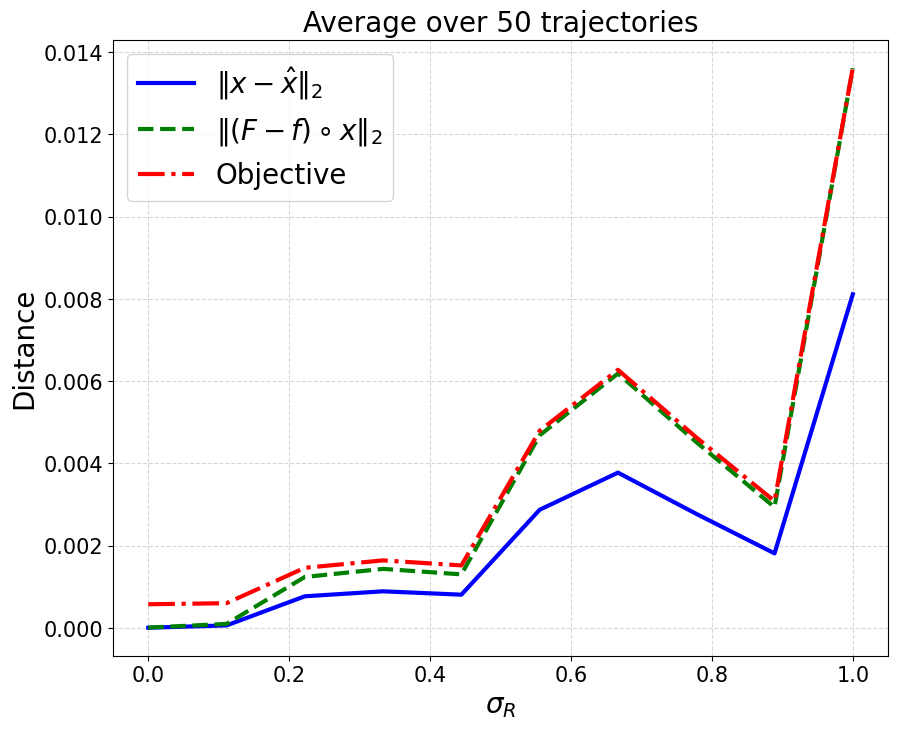

In [102]:
plotter(noise_arr, x_mean, d_mean, c_mean, f'Average over {n_sample} trajectories', 'logistic_mean', )

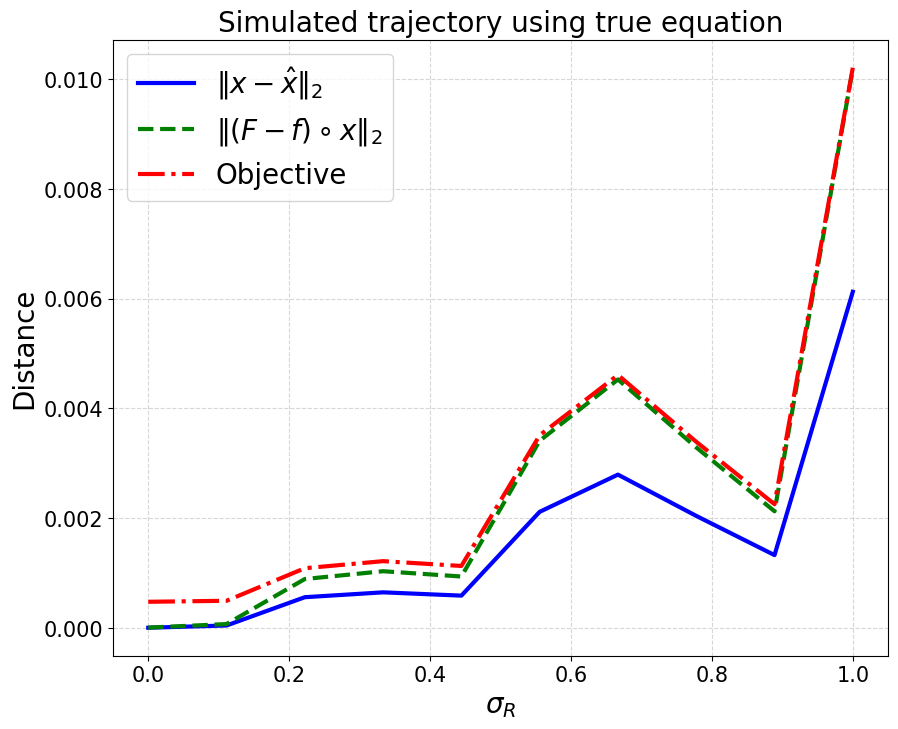

In [103]:
plotter(noise_arr, x_ind, d_ind, c_ind, f'Simulated trajectory using true equation', 'logistic_ind', )

### **2d damped linear oscillator**

In [80]:
T = 0.12
freq = 100
n_sample = 50
seed = 0
n_seed = 1
results_osc = defaultdict(dict)


for noise_sigma in noise_arr:
  ode = equations.get_ode('LinearOSC', None)
  path_base = 'results_vi/{}/noise-{}/sample-{}/freq-{}/'.format('LinearOSC', noise_sigma, n_sample, freq)
  res = []
  for s in range(ode.dim_x):
    if s ==0:
      path = path_base + 'grad_seed_{}.pkl'.format(s)
      with open(path, 'rb') as f:
        res.append(pickle.load(f))
    else:
      path = path_base + 'grad_x_{}_seed_{}.pkl'.format(s, 0)
      with open(path, 'rb') as f:
        res.append(pickle.load(f))

  f_hat_list = [model['model'].execute for model in res]
  for s in range(ode.dim_x):
    results_osc[f'noise_sigma = {noise_sigma}'][f'metric_instance_{s}'] = Metric(s, ode, f_hat_list, T, 200, n_sample)
    coefficients_dict = res[s]['f_hat'].as_coefficients_dict()
    coefficients = np.array(list(coefficients_dict.values())).astype(float)
    results_osc[f'noise_sigma = {noise_sigma}'][f'equation_{s}_lambda'] = np.linalg.norm(coefficients)

In [81]:
results_osc

defaultdict(dict,
            {'noise_sigma = 0.0': {'metric_instance_0': <evaluation_utils.Metric at 0x7e0beab77910>,
              'equation_0_lambda': 1.4142135623730951,
              'metric_instance_1': <evaluation_utils.Metric at 0x7e0beab74100>,
              'equation_1_lambda': 1.4142135623730951},
             'noise_sigma = 0.1111111111111111': {'metric_instance_0': <evaluation_utils.Metric at 0x7e0beab77370>,
              'equation_0_lambda': 1.4142135623730951,
              'metric_instance_1': <evaluation_utils.Metric at 0x7e0beab77d90>,
              'equation_1_lambda': 1.4142135623730951},
             'noise_sigma = 0.2222222222222222': {'metric_instance_0': <evaluation_utils.Metric at 0x7e0beab74340>,
              'equation_0_lambda': 1.0,
              'metric_instance_1': <evaluation_utils.Metric at 0x7e0beab776d0>,
              'equation_1_lambda': 1.0},
             'noise_sigma = 0.3333333333333333': {'metric_instance_0': <evaluation_utils.Metric at 0x7e0be

In [68]:
sum_lambda_dict = {}
for noise_sigma in noise_arr:
  sum_lambda = 0
  for s in range(ode.dim_x):
    sum_lambda += results_osc[f'noise_sigma = {noise_sigma}'][f'equation_{s}_lambda']
  sum_lambda_dict[noise_sigma] = sum_lambda

In [79]:
lambda_sum = np.max(np.array(list(sum_lambda_dict.values())).astype(float))
t_eff = 1 / lambda_sum**2
t_eff

0.12499999999999997

In [104]:
x_mean, d_mean, c_mean = [], [], []
n_basis = 40
for i in range(len(noise_arr)):
  x_mean.append(np.mean(results_osc[f'noise_sigma = {noise_arr[i]}']['metric_instance_0'].x_norm()[0] + results_osc[f'noise_sigma = {noise_arr[i]}']['metric_instance_0'].x_norm()[1]))
  d_mean.append(np.mean(results_osc[f'noise_sigma = {noise_arr[i]}']['metric_instance_1'].d_x() + results_osc[f'noise_sigma = {noise_arr[i]}']['metric_instance_0'].d_x()))
  c_mean.append(np.mean(np.sqrt(results_osc[f'noise_sigma = {noise_arr[i]}']['metric_instance_1'].C_fxg(n_basis)) + np.sqrt(results_osc[f'noise_sigma = {noise_arr[i]}']['metric_instance_0'].C_fxg(n_basis))))

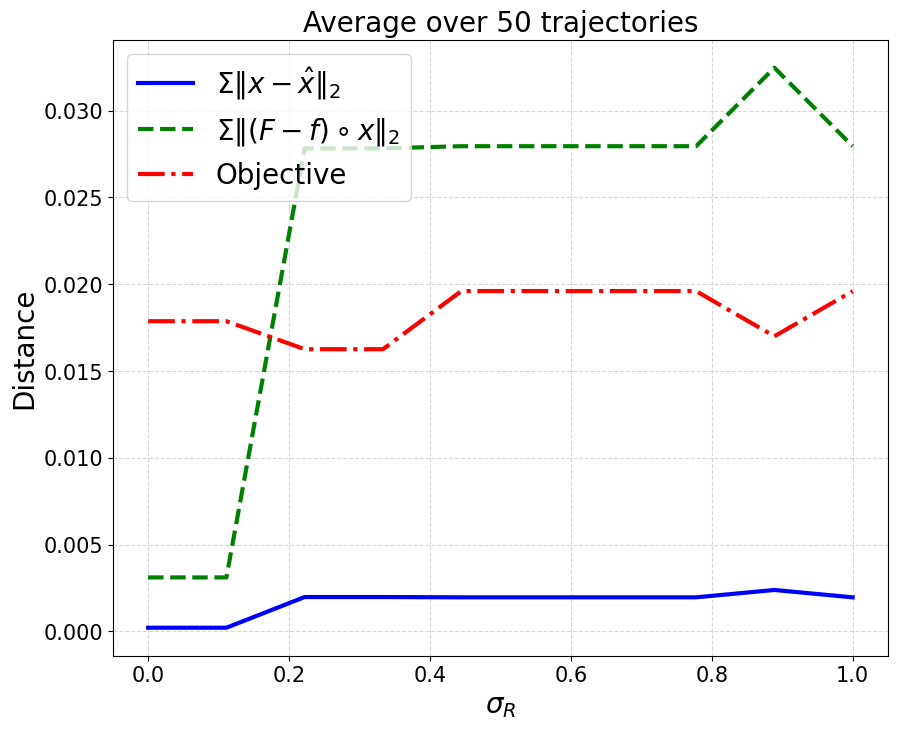

In [105]:
plotter(noise_arr, x_mean, d_mean, c_mean, f'Average over {n_sample} trajectories', 'osc_mean', one_d = False)